In [1]:
%load_ext rpy2.ipython
# Turning on in-IPy R capabilities

In [2]:
%%R
library(phyloseq)
library(doParallel)
library(ggplot2)
library(vegan)
library(RColorBrewer)
library(plyr)

Loading required package: foreach
foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Need help? Try the ggplot2 mailing list: http://groups.google.com/group/ggplot2.
Loading required package: permute
Loading required package: lattice
This is vegan 2.2-1


In [7]:
%%R
#Creating the physeq object from our tree and biom table with taxonomic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../data/otu_table_tax_no211_meta.biom", treefilename = "../data/ssu-aln.bacteria.mask.tre",
                    parseFunction = parse_taxonomy_greengenes)

In [8]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
physeq_snorm = transform_sample_counts(physeq, function(x) x / sum(x))

In [20]:
%%R
# Computing the weighted unifrac distance matrix using the new "fast" algorithm, then performing a PCoA, in parallel
registerDoParallel(cores=10)
ord.full = ordinate(physeq_snorm, method = "PCoA", distance = "unifrac", weighted = TRUE, fast = TRUE, parallel = TRUE)

In [37]:
%%R
# Subsetting the data by day and by treatment
physeq_snorm.D0 = prune_samples(sample_data(physeq_snorm)$Day=="0", physeq_snorm)
physeq_snorm.D1 = prune_samples(sample_data(physeq_snorm)$Day=="1", physeq_snorm)
physeq_snorm.D2 = prune_samples(sample_data(physeq_snorm)$Day=="2", physeq_snorm)
physeq_snorm.Soil = prune_samples(sample_data(physeq_snorm)$Amdmt=="0", physeq_snorm)
physeq_snorm.PyOM = prune_samples(sample_data(physeq_snorm)$Amdmt=="1", physeq_snorm)
physeq_snorm.Stover = prune_samples(sample_data(physeq_snorm)$Amdmt=="2", physeq_snorm)

In [38]:
%%R
# Computing the weighted unifrac distance matrix for each subset (by day or amendment),
# then performing a PCoA, in parallel
registerDoParallel(cores=10)
ord.D0 = ordinate(physeq_snorm.D0, method = "PCoA", distance = "unifrac", weighted = TRUE, fast = TRUE, parallel = TRUE)
ord.D1 = ordinate(physeq_snorm.D1, method = "PCoA", distance = "unifrac", weighted = TRUE, fast = TRUE, parallel = TRUE)
ord.D2 = ordinate(physeq_snorm.D2, method = "PCoA", distance = "unifrac", weighted = TRUE, fast = TRUE, parallel = TRUE)
ord.Soil = ordinate(physeq_snorm.Soil, method = "PCoA", distance = "unifrac", weighted = TRUE, fast = TRUE, parallel = TRUE)
ord.PyOM = ordinate(physeq_snorm.PyOM, method = "PCoA", distance = "unifrac", weighted = TRUE, fast = TRUE, parallel = TRUE)
ord.Stover = ordinate(physeq_snorm.Stover, method = "PCoA", distance = "unifrac", weighted = TRUE, fast = TRUE, parallel = TRUE)

In [39]:
%%R
# Takes the plot_ordination command, but doesn't actually plot it - just reports the dataframe ("justDF").
# It uses the metadata from the normalize physeq file, and looks only at the first few axes.
PCoA.full = plot_ordination(physeq_snorm, ord.full, axes = c(1,2,3), justDF = TRUE)
PCoA.D0 = plot_ordination(physeq_snorm.D0, ord.D0, axes = c(1,2,3), justDF = TRUE)
PCoA.D1 = plot_ordination(physeq_snorm.D1, ord.D1, axes = c(1,2,3), justDF = TRUE)
PCoA.D2 = plot_ordination(physeq_snorm.D2, ord.D2, axes = c(1,2,3), justDF = TRUE)
PCoA.Soil = plot_ordination(physeq_snorm.Soil, ord.Soil, axes = c(1,2,3), justDF = TRUE)
PCoA.PyOM = plot_ordination(physeq_snorm.PyOM, ord.PyOM, axes = c(1,2,3), justDF = TRUE)
PCoA.Stover = plot_ordination(physeq_snorm.Stover, ord.Stover, axes = c(1,2,3), justDF = TRUE)
head(PCoA.full)

           Axis.1       Axis.2        Axis.3 Plants DayAmdmt Amdmt ID Day
S009  0.034327631  0.035297548 -0.0240329228      1       01     1  D   0
S204  0.005325693 -0.022388952 -0.0006709273      1       21     1  D   2
S112  0.005004872  0.003006004  0.0328200537      0       11     1  B   1
S247 -0.026790830 -0.022938576 -0.0302909965      0       22     2  F   2
S026  0.025672941  0.013004135 -0.0388705367      0       00     0  A   0
S023  0.038372924  0.044959801 -0.0301599812      1       00     0  C   0


In [41]:
%%R
colnames(PCoA.full)

[1] "Axis.1"   "Axis.2"   "Axis.3"   "Plants"   "DayAmdmt" "Amdmt"    "ID"      
[8] "Day"     


In [49]:
%%R
D <- PCoA.full
# Sets the relevant ordination

colnames(D)[1:3]<-c("PCo1","PCo2","PCo3")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))

D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))
D$strip = paste(D$DayName)
#D$strip<-as.factor(D$strip)

head(D)

             PCo1         PCo2          PCo3 Plants DayAmdmt Amdmt ID Day
S009  0.034327631  0.035297548 -0.0240329228      1       01     1  D   0
S204  0.005325693 -0.022388952 -0.0006709273      1       21     1  D   2
S112  0.005004872  0.003006004  0.0328200537      0       11     1  B   1
S247 -0.026790830 -0.022938576 -0.0302909965      0       22     2  F   2
S026  0.025672941  0.013004135 -0.0388705367      0       00     0  A   0
S023  0.038372924  0.044959801 -0.0301599812      1       00     0  C   0
     AmdmtName DayName  strip
S009      PyOM   Day 1  Day 1
S204      PyOM  Day 82 Day 82
S112      PyOM  Day 12 Day 12
S247    Stover  Day 82 Day 82
S026 Soil only   Day 1  Day 1
S023 Soil only   Day 1  Day 1


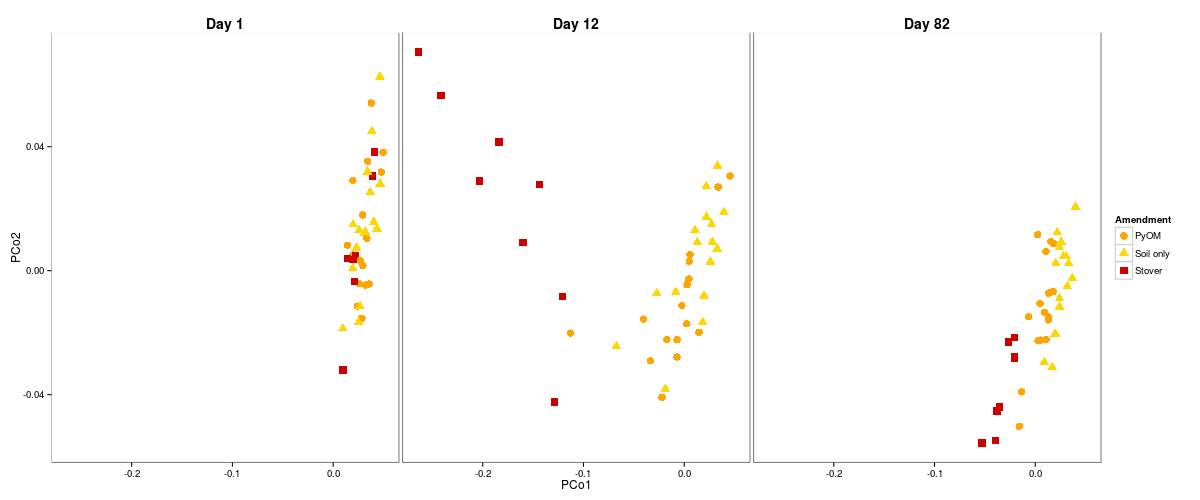

In [125]:
%%R -h 500 -w 1200
D <- PCoA.full
# Sets the relevant ordination

colnames(D)[1:3]<-c("PCo1","PCo2","PCo3")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))

D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))
D$strip = paste(D$DayName)
#D$strip<-as.factor(D$strip)

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = PCo1, y = PCo2, color = AmdmtName, shape = AmdmtName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("orange","gold1","red3"))

p = p + guides(colour = guide_legend("Amendment"), shape = guide_legend("Amendment"))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
# p = p + facet_wrap(~strip, scales = "free")
# The axis scales could be all optimized individually
p = p + facet_wrap(~DayName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
p

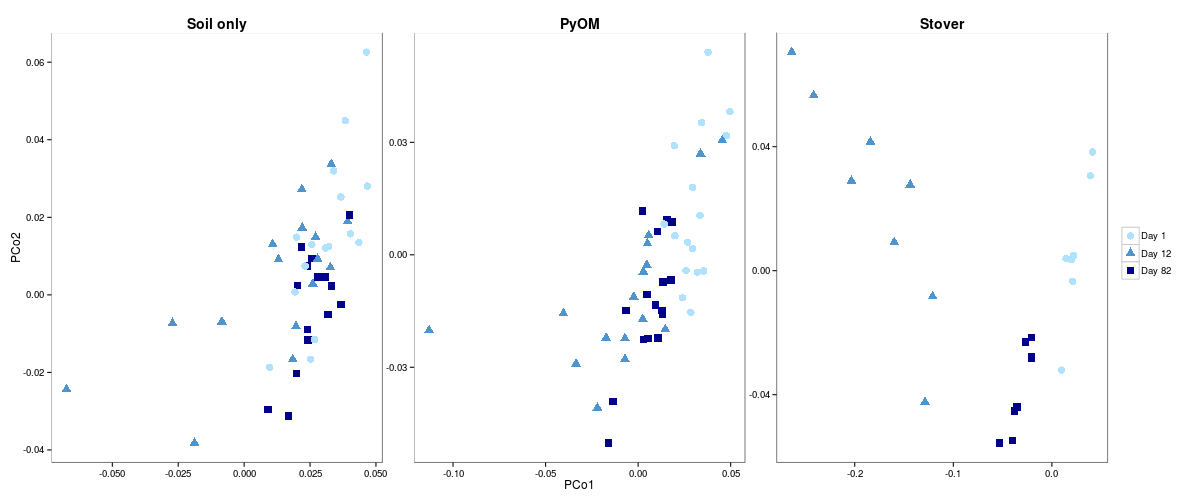

In [126]:
%%R -h 500 -w 1200
D <- PCoA.full
# Sets the relevant ordination

colnames(D)[1:3]<-c("PCo1","PCo2","PCo3")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))

D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = PCo1, y = PCo2, color = DayName, shape = DayName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("lightskyblue1","steelblue3","blue4"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~AmdmtName, scales = "free")
# The axis scales could be all optimized individually
# p = p + facet_wrap(~strip)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
p

Joining by: Axis.1, Axis.2, Axis.3, Plants, DayAmdmt, Amdmt, ID, Day
Joining by: Axis.1, Axis.2, Axis.3, Plants, DayAmdmt, Amdmt, ID, Day


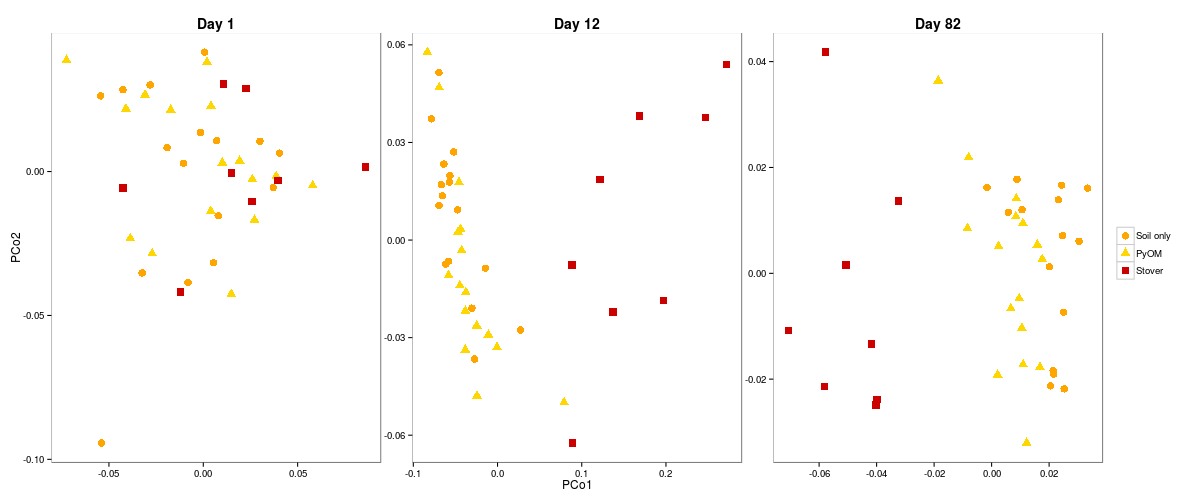

In [127]:
%%R -h 500 -w 1200

D<-join(PCoA.D0,PCoA.D1, type="full")
D<-join(D,PCoA.D2, type="full")
head(D)
# Joins the PCoAs done separately by days

colnames(D)[1:3]<-c("PCo1","PCo2","PCo3")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))

D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = PCo1, y = PCo2, color = AmdmtName, shape = AmdmtName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("orange","gold1","red3"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~DayName, scales = "free")
# The axis scales could be all optimized individually
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
p

Joining by: Axis.1, Axis.2, Axis.3, Plants, DayAmdmt, Amdmt, ID, Day
Joining by: Axis.1, Axis.2, Axis.3, Plants, DayAmdmt, Amdmt, ID, Day


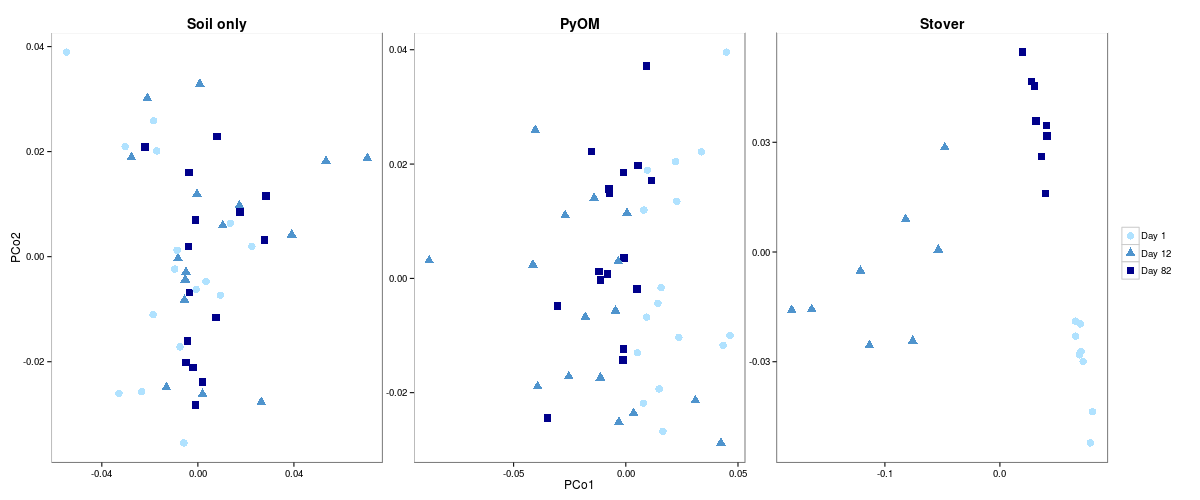

In [128]:
%%R -h 500 -w 1200
D<-join(PCoA.Soil,PCoA.PyOM, type="full")
D<-join(D,PCoA.Stover, type="full")
head(D)
# Joins the PCoAs done separately by days
# Sets the relevant ordination

colnames(D)[1:3]<-c("PCo1","PCo2","PCo3")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))

D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = PCo1, y = PCo2, color = DayName, shape = DayName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("lightskyblue1","steelblue3","blue4"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~AmdmtName, scales = "free")
# The axis scales could be all optimized individually
# p = p + facet_wrap(~strip)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
p